## Model Tuning

In [4]:
import sys
import inspect

#Add the scripts directory to the sys path
sys.path.append("../src/data")
sys.path.append("../src/features")

from make_dataset import get_data
from data_processor import DataProcessor

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [6]:
# Show all rows and columns in the display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#get the train data
X_train, y_train = get_data(data_string="train")

In [9]:
#get the test data
X_test, y_test = get_data(data_string="test")

### Baseline Model 

Lets create a baseline model. In this case, let's say our predicted value is median of y_train

In [10]:
y_pred = pd.Series(np.zeros(len(y_test)))
y_pred[:] = y_train.median()

In [11]:
mean_absolute_error(y_test, y_pred)

0.06970475324840691

##### Baseline model MAE is 0.0697

Gradient Boosting has the best score among all three models.. 

XGBoost is generally better over Gradient Boosting Model as XGBoost is a regualarized model that controls over fitting and in addition XGBoost is also better in terms of speed and memory utilization

Lets find the best XGBoost model using hyperparameter tuning

### Other Models

There are more than 500 columns and hence trying different models such as Random Forest, Gradient Boosting, XGBoost will take a lot of time. Also, Linear Regression doesn't take much time to run. Hence, lets try with Linear Regression first and then try the XGBoost model. Also, hypertune the parameters of XGBoost model.

#### 1. Linear Regression

In [12]:
dp = DataProcessor(cols_to_remove=["parcelid", "propertyzoningdesc", "rawcensustractandblock", "regionidneighborhood", "regionidzip", "censustractandblock"], 
                  datecol="transactiondate")

lin_reg = LinearRegression(n_jobs=-1)

pipeline = Pipeline([
    ("dataprocessor", dp),
    ("lin_reg", lin_reg)
])
    
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("mean absolute error: {0:.4f}".format(mean_absolute_error(y_test, y_pred)))

mean absolute error: 0.2805


##### Linear Regression MAE is worse than our baseline model. 

#### 2. XGBoost

In [17]:
dp = DataProcessor(cols_to_remove=["parcelid", "propertyzoningdesc", "rawcensustractandblock", "regionidneighborhood", "regionidzip", "censustractandblock"], 
                  datecol="transactiondate")

xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.01, n_estimators = 1000, objective='reg:squarederror', 
                                    eval_metric="mae", random_state = 42, verbosity=1, n_thread=-1)

pipeline = Pipeline([
    ("dataprocessor", dp),
    ("xgb_reg", xgb_reg)
])
    
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("mean absolute error: {0:.4f}".format(mean_absolute_error(y_test, y_pred)))

mean absolute error: 0.0862


#### XGBoost MAE is also worse than the baseline model. Lets hypertune the XGboost model to see if we can reduce the MAE

### Hypertuning

In [45]:
def modelfit(xgb_reg, X_train, y_train, X_test, y_test):
    
    xgb_param = xgb_reg.get_xgb_params()
    
    num_boost_round = xgb_reg.get_params()['n_estimators']
    num_boost_round

    xgb_train = xgb.DMatrix(X_train, y_train) 

    cv_results = xgb.cv(xgb_param, xgb_train, num_boost_round=num_boost_round, nfold=3, metrics='mae', early_stopping_rounds=50)

    # print("\n---- cv results ----\n\n", cv_results)
    # print("\nCV test results best - MAE: {}, ".format(cv_results['test-mae-mean'].min()))
    print("\nBest estimators :", cv_results.shape[0])
    
    xgb_reg.set_params(n_estimators=cv_results.shape[0])

    xgb_reg.fit(X_train, y_train, eval_metric='mae')

    dtrain_pred = xgb_reg.predict(X_train)

    print("\nTrain MAE: {}".format(mean_absolute_error(y_train, dtrain_pred)))
    
    dtest_pred = xgb_reg.predict(X_test)
    
    print("\nTest MAE: {}".format(mean_absolute_error(y_test, dtest_pred)))

    plt.figure(figsize=(20,15))
    xgb.plot_importance(xgb_reg, ax=plt.gca())

In [27]:
dp = DataProcessor(cols_to_remove=["parcelid", "propertyzoningdesc", "rawcensustractandblock", "regionidneighborhood", "regionidzip", "censustractandblock"], 
                  datecol="transactiondate")

X_train_transformed = dp.fit_transform(X_train)
X_test_transformed = dp.transform(X_test)

#### Step 1: Fix learning_rate and n_estimators


---- cv results ----
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         0.448882       0.000110       0.448917      0.000284
1         0.405898       0.000100       0.405959      0.000315
2         0.367337       0.000093       0.367396      0.000342
3         0.332898       0.000133       0.332981      0.000340
4         0.302052       0.000147       0.302154      0.000361
5         0.274483       0.000182       0.274611      0.000399
6         0.249853       0.000225       0.250022      0.000411
7         0.227949       0.000241       0.228121      0.000447
8         0.208345       0.000273       0.208550      0.000440
9         0.190963       0.000316       0.191183      0.000442
10        0.175497       0.000322       0.175735      0.000460
11        0.161753       0.000333       0.162017      0.000478
12        0.149562       0.000358       0.149844      0.000497
13        0.138779       0.000371       0.139064      0.000509
14        0.129244       0.00039

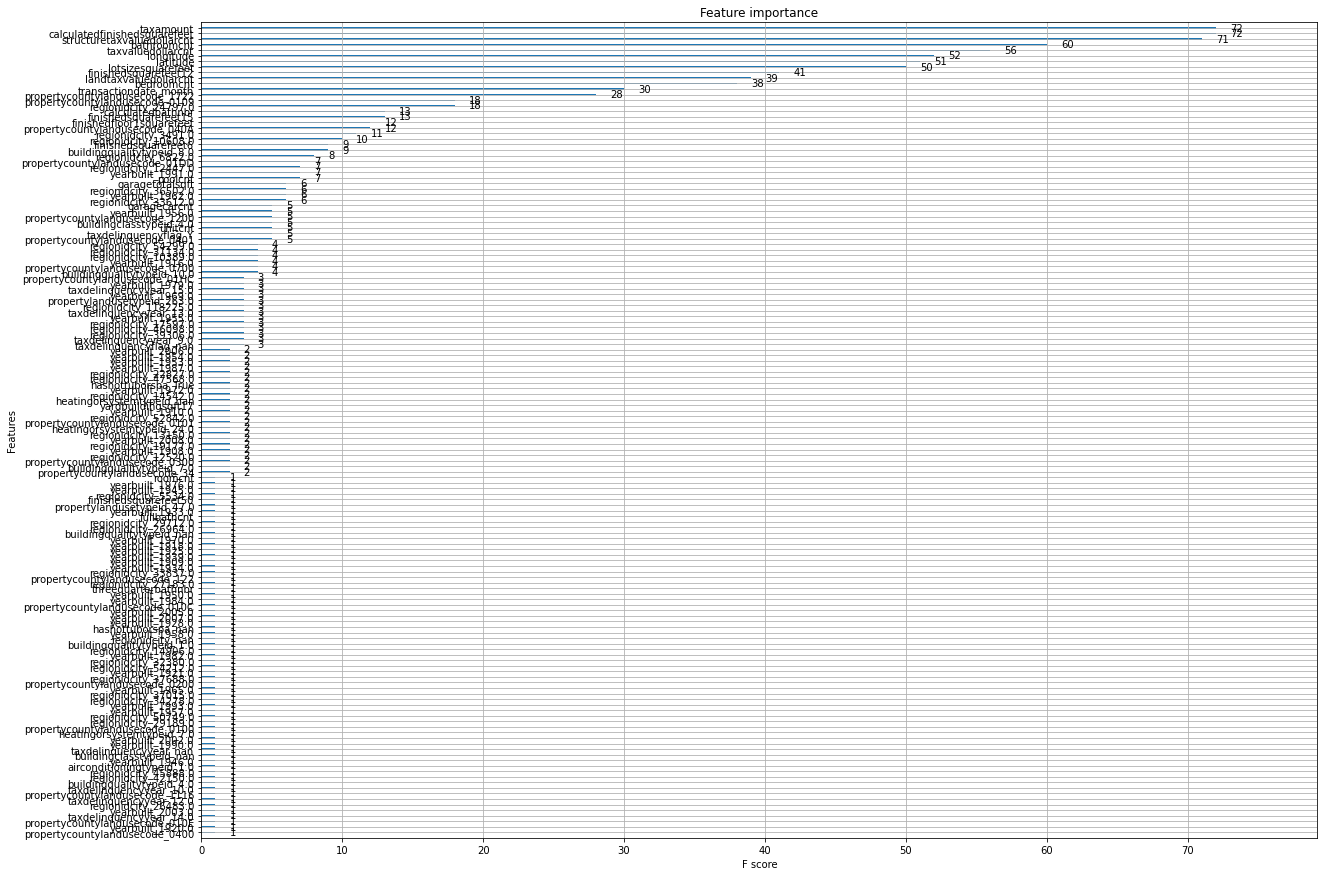

In [29]:
xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=5, 
                                   min_child_weight=1, gamma=0, max_delta_step=0, 
                                   subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, 
                                   colsample_bynode=1, reg_lambda=1, reg_alpha=0, scale_pos_weight=1,
                                   missing=None, objective='reg:squarederror', eval_metric='mae', 
                                   seed=0, booster='gbtree')#, verbosity=0, nthread=-1

modelfit(xgb_reg, X_train_transformed, y_train, X_test_transformed, y_test)

learning_rate is 0.1 and n_estimators is 64

In [35]:
def xgb_gridsearch(param_test, xgb_reg):
    
    dp = DataProcessor(cols_to_remove=["parcelid", "propertyzoningdesc", "rawcensustractandblock", "regionidneighborhood", "regionidzip", "censustractandblock"], 
                      datecol="transactiondate")

    pipeline = Pipeline([
        ("dataprocessor", dp),
        ("xgb_reg", xgb_reg)
    ])

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_test, scoring="neg_mean_absolute_error", 
                               n_jobs=-1, cv=3, verbose=1)

    grid_search.fit(X_train, y_train)

    print("----- Grid Search cv results ----- \n")
    for mean_score, params in zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]):
        print(-(mean_score), params)

    print("\n----- Grid Search best parameters ------ \n", grid_search.best_params_)
    print("\n")
    print("----- Grid Search best score ------ \n", -(grid_search.best_score_))
    
    

#### Step 2: Tune max_depth and min_child_weight

In [36]:
param_test = {
    "xgb_reg__max_depth": [3, 5, 7, 9],
    "xgb_reg__min_child_weight": [1, 3, 5, 7]    
}

xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.1, n_estimators=64, max_depth=5, 
                                    min_child_weight=1, gamma=0, max_delta_step=0, 
                                    subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, 
                                    colsample_bynode=1, reg_lambda=1, reg_alpha=0, 
                                    scale_pos_weight=1, missing=None, objective='reg:squarederror', 
                                    eval_metric='mae', seed=0, booster='gbtree')# , verbosity=0, nthread=-1)

xgb_gridsearch(param_test, xgb_reg)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.5min finished


----- Grid Search cv results ----- 

0.068367011357071 {'xgb_reg__max_depth': 3, 'xgb_reg__min_child_weight': 1}
0.06843673997095884 {'xgb_reg__max_depth': 3, 'xgb_reg__min_child_weight': 3}
0.06844662104971753 {'xgb_reg__max_depth': 3, 'xgb_reg__min_child_weight': 5}
0.06842856436586882 {'xgb_reg__max_depth': 3, 'xgb_reg__min_child_weight': 7}
0.06857047248524396 {'xgb_reg__max_depth': 5, 'xgb_reg__min_child_weight': 1}
0.06884404940434846 {'xgb_reg__max_depth': 5, 'xgb_reg__min_child_weight': 3}
0.0689291133486562 {'xgb_reg__max_depth': 5, 'xgb_reg__min_child_weight': 5}
0.06882931759200568 {'xgb_reg__max_depth': 5, 'xgb_reg__min_child_weight': 7}
0.06993238334229862 {'xgb_reg__max_depth': 7, 'xgb_reg__min_child_weight': 1}
0.06967881668799174 {'xgb_reg__max_depth': 7, 'xgb_reg__min_child_weight': 3}
0.06957452943156629 {'xgb_reg__max_depth': 7, 'xgb_reg__min_child_weight': 5}
0.06940498766098192 {'xgb_reg__max_depth': 7, 'xgb_reg__min_child_weight': 7}
0.0704343804381625 {'xgb_reg__

Now, we can narrow our search with max_depth around 2,3,4 and min_child_weight around 0,1,2. \
But lets stick with our best max_depth and min_child_weight

max_depth is 3 and min_child_weight is 1.

#### Step 3: Tune gamma

In [38]:
param_test = {
    'xgb_reg__gamma': [i/10.0 for i in range(0, 5, 1)]
}

xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.1, n_estimators=64, max_depth=3, 
                                    min_child_weight=1, gamma=0, max_delta_step=0, 
                                    subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, 
                                    colsample_bynode=1, reg_lambda=1, reg_alpha=0, 
                                    scale_pos_weight=1, missing=None, objective='reg:squarederror', 
                                    eval_metric='mae', seed=0, booster='gbtree')# , verbosity=0, nthread=-1)

xgb_gridsearch(param_test, xgb_reg)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   51.2s finished


----- Grid Search cv results ----- 

0.068367011357071 {'xgb_reg__gamma': 0.0}
0.06836192916076182 {'xgb_reg__gamma': 0.1}
0.06835831122947307 {'xgb_reg__gamma': 0.2}
0.06837342144716256 {'xgb_reg__gamma': 0.3}
0.0683457988900969 {'xgb_reg__gamma': 0.4}

----- Grid Search best parameters ------ 
 {'xgb_reg__gamma': 0.4}


----- Grid Search best score ------ 
 0.0683457988900969


gamma is 0.4

Before tuning further lets recalibrate the number of boosting rounds with these parameters and also see how we are doing on test dataset


---- cv results ----
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         0.448894       0.000112       0.448930      0.000273
1         0.405939       0.000093       0.405975      0.000325
2         0.367387       0.000100       0.367436      0.000345
3         0.332972       0.000145       0.333025      0.000345
4         0.302149       0.000179       0.302212      0.000375
5         0.274586       0.000181       0.274676      0.000407
6         0.250004       0.000221       0.250079      0.000417
7         0.228083       0.000258       0.228190      0.000456
8         0.208520       0.000299       0.208617      0.000449
9         0.191138       0.000320       0.191264      0.000451
10        0.175697       0.000327       0.175825      0.000474
11        0.161968       0.000344       0.162108      0.000486
12        0.149810       0.000363       0.149950      0.000501
13        0.139031       0.000378       0.139180      0.000510
14        0.129530       0.00040

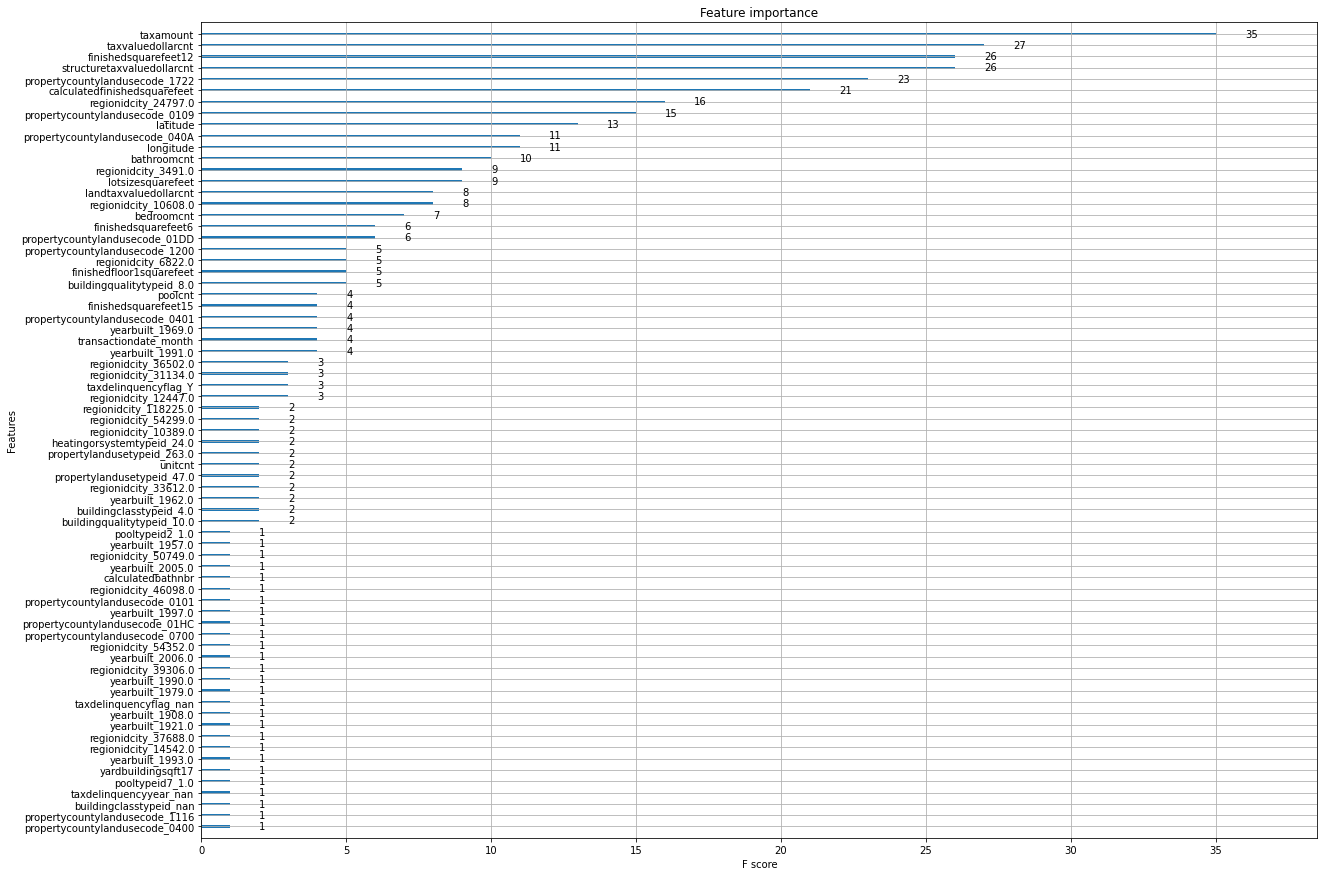

In [40]:
xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=3, 
                                   min_child_weight=1, gamma=0.4, max_delta_step=0, 
                                   subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, 
                                   colsample_bynode=1, reg_lambda=1, reg_alpha=0, scale_pos_weight=1,
                                   missing=None, objective='reg:squarederror', eval_metric='mae', 
                                   seed=0, booster='gbtree')#, verbosity=0, nthread=-1

modelfit(xgb_reg, X_train_transformed, y_train, X_test_transformed, y_test)

let's use n_estimators as 79

#### Step 4: Tune subsample and colsample_bytree

In [42]:
param_test = {
    'xgb_reg__subsample': [i/10.0 for i in range(6,11)],
    'xgb_reg__colsample_bytree': [i/10.0 for i in range(6,11)]
}
xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.1, n_estimators=79, max_depth=3, 
                                    min_child_weight=1, gamma=0.4, max_delta_step=0, 
                                    subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, 
                                    colsample_bynode=1, reg_lambda=1, reg_alpha=0, 
                                    scale_pos_weight=1, missing=None, objective='reg:squarederror', 
                                    eval_metric='mae', seed=0, booster='gbtree')# , verbosity=0, nthread=-1)

xgb_gridsearch(param_test, xgb_reg)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.7min finished


----- Grid Search cv results ----- 

0.06839583475591497 {'xgb_reg__colsample_bytree': 0.6, 'xgb_reg__subsample': 0.6}
0.06838293031021495 {'xgb_reg__colsample_bytree': 0.6, 'xgb_reg__subsample': 0.7}
0.06835182403442903 {'xgb_reg__colsample_bytree': 0.6, 'xgb_reg__subsample': 0.8}
0.06830213833189408 {'xgb_reg__colsample_bytree': 0.6, 'xgb_reg__subsample': 0.9}
0.06826052365171864 {'xgb_reg__colsample_bytree': 0.6, 'xgb_reg__subsample': 1.0}
0.06841176117271881 {'xgb_reg__colsample_bytree': 0.7, 'xgb_reg__subsample': 0.6}
0.06839664950181905 {'xgb_reg__colsample_bytree': 0.7, 'xgb_reg__subsample': 0.7}
0.06836351622720327 {'xgb_reg__colsample_bytree': 0.7, 'xgb_reg__subsample': 0.8}
0.06832963656433833 {'xgb_reg__colsample_bytree': 0.7, 'xgb_reg__subsample': 0.9}
0.06826566901542264 {'xgb_reg__colsample_bytree': 0.7, 'xgb_reg__subsample': 1.0}
0.06843522737207429 {'xgb_reg__colsample_bytree': 0.8, 'xgb_reg__subsample': 0.6}
0.06840209845007887 {'xgb_reg__colsample_bytree': 0.8, 'xgb_r

colsample_bytree is 0.9 and subsample is 1.0

#### Step 5: Tune regularization parameters

In [44]:
param_test = {
    'xgb_reg__reg_alpha': [0.00001, 0.01, 0.1, 1, 100]
}

xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.1, n_estimators=79, max_depth=3, 
                                    min_child_weight=1, gamma=0.4, max_delta_step=0, 
                                    subsample=1.0, colsample_bytree=0.9, colsample_bylevel=1, 
                                    colsample_bynode=1, reg_lambda=1, reg_alpha=0, 
                                    scale_pos_weight=1, missing=None, objective='reg:squarederror', 
                                    eval_metric='mae', seed=0, booster='gbtree')# , verbosity=0, nthread=-1)

xgb_gridsearch(param_test, xgb_reg)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   58.6s finished


----- Grid Search cv results ----- 

0.06824747447722579 {'xgb_reg__reg_alpha': 1e-05}
0.06823891939905889 {'xgb_reg__reg_alpha': 0.01}
0.06826877040720171 {'xgb_reg__reg_alpha': 0.1}
0.06819219940625887 {'xgb_reg__reg_alpha': 1}
0.06854582497062302 {'xgb_reg__reg_alpha': 100}

----- Grid Search best parameters ------ 
 {'xgb_reg__reg_alpha': 1}


----- Grid Search best score ------ 
 0.06819219940625887


reg_alpha is 1

#### Step 6: Reducing Learning Parameters

Lets reducing the learning rate and increase the number of trees


Best estimators : 1039

Train MAE: 0.06777621102696925

Test MAE: 0.06999448546058179


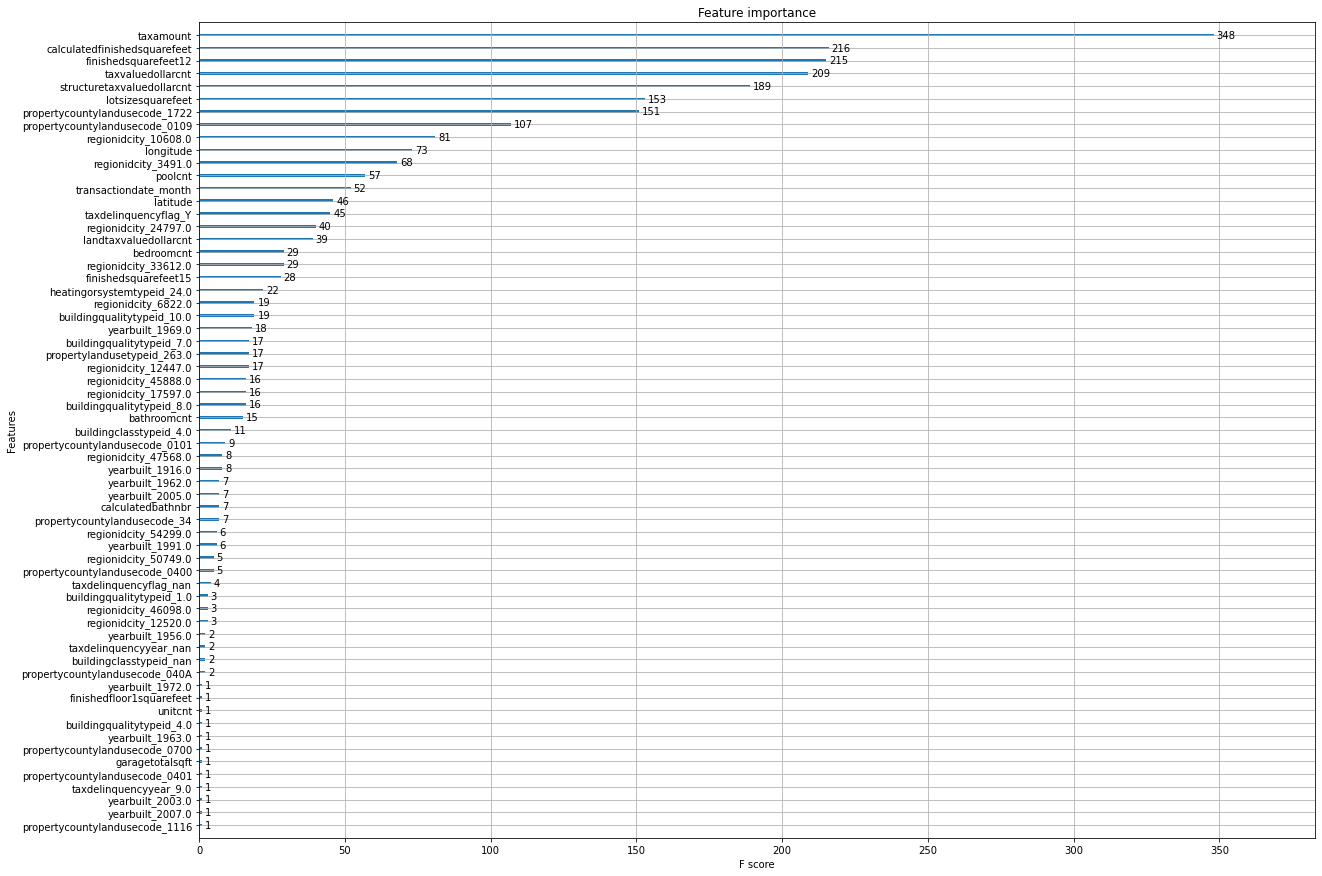

In [46]:
xgb_reg = xgb.sklearn.XGBRegressor(learning_rate=0.01, n_estimators=5000, max_depth=3, 
                                   min_child_weight=1, gamma=0.4, max_delta_step=0, 
                                   subsample=1.0, colsample_bytree=0.9, colsample_bylevel=1, 
                                   colsample_bynode=1, reg_lambda=1, reg_alpha=1, scale_pos_weight=1,
                                   missing=None, objective='reg:squarederror', eval_metric='mae', 
                                   seed=0, booster='gbtree')#, verbosity=0, nthread=-1

modelfit(xgb_reg, X_train_transformed, y_train, X_test_transformed, y_test)

Our final set of parameters are 

learning_rate=0.01, \
n_estimators=1039, \
max_depth=3, \
min_child_weight=1, \
gamma=0.4, \
max_delta_step=0, \
subsample=1.0, \
colsample_bytree=0.9, \
colsample_bylevel=1, \
colsample_bynode=1, \
reg_lambda=1, \
reg_alpha=1, \
scale_pos_weight=1, \
missing=None, \
objective='reg:squarederror', \
eval_metric='mae', \
seed=0, \
booster='gbtree' \

##### We have reduced the XGBoost MAE by 19% (0.0862 to 0.0699) after hypertuning the model. 
##### Its still less than Baseline MAE (0.0697) but almost same. We can try some more feature engineering, dimenisonality reduction and also try other models such as Gradient Boosting Model, Adaboost to see if we can get better model than baseline. For now, lets create the final model using XGBoost and use for predidctions.
